# CAPSTONE 2 - CAR SHARING DELIVERY OPTIONS EXPERIMENT
The data was scrapped from the website "Turo.com"  - the biggest car sharing platform (by google).
We would like to find out if the * delivery to the main airport has significant difference in utilisation rate * for the car on the platform. 

For the experiment we will define two groups (A/B) of cars within one area within one area who does and doesn't do delivery. (We will hire part of the owners to do delivery)
We will observe for three months within one season the results to see if there are significant difference between cars who don't do delivery to the Airport and those who do.
We will look at the normalized data within category of cars.
The baseline month will be Marh 2018.

** STEPS ** :
1. Prepare the baseline 
    - Clean the data
    - Build the graphs
    - Confirm the baseline
2. Define the sample size (make sure the sample conclude all random listings)
3. Conduct the exeriment
4. Calculate the difference between the two A/B groups
5. Calculate T-test for the experiment

We would need to select a state and then decide what territory we will cover. We decided to narrow our experiment to California. 
We've got 14000 active listings in the state (Out 11). The data contains a valuable ba
We have a field on our data - "Airport Delivery fee" it's the delivery to the closest airport. 

In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
%matplotlib inline
import seaborn as sns
from pandas import ExcelWriter
from pandas import ExcelFile
import math as mt


In [24]:
df = pd.read_excel ('Workbook_Turo_March.xlsx',
    sheet_name='DATA',
    skiprows=[1] # header data
)

In [27]:
#filtering only Active listings
df = df[df['Status'] =="Active"]
df = df[df['State'] == 'CA']
#replace column name
df.rename(columns={'Airport Delivery fee':'fee'}, inplace=True)

In [5]:
df = df[pd.to_numeric(df['Latitude'], errors='coerce').notnull()]
df['Latitude'] = df.Latitude.astype(float)

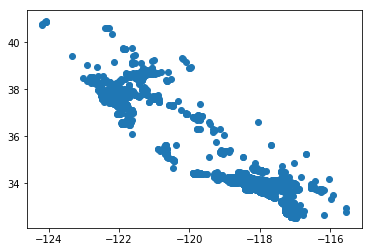

In [26]:
#mapping our location distribution all over the CA
import matplotlib.pyplot as plt
plt.scatter(x=df ['Longitude'], y=df['Latitude'])
plt.show()

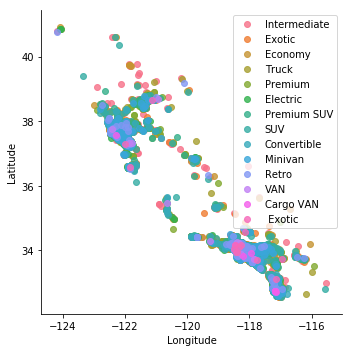

In [7]:
sns.lmplot( x="Longitude", y="Latitude", data=df, fit_reg=False, hue='Category', legend=False)
 
# Move the legend to an empty part of the plot
plt.legend(loc='upper right')

In [28]:
df.describe ()

,Car ID,Year,Number of seats,Number of doors,GPS,Booking Instantly,Longitude,Owner ID,Price per day,"Distance Included/day, Miles, KM",...,Reviews number,Owner rate,Airport ride needed,Business class,numberOfFaqs,minimumAgeInYearsToRent,numberOfFavorites,highValueVehicle,frequentlyBooked,dateRangeRate
count,14383.000000,14383.000000,11508.000000,12035.000000,7017.0,14383.000000,14383.000000,1.438300e+04,14383.000000,13903.000000,...,14383.000000,8103.000000,10528.000000,14383.000000,14383.000000,9684.000000,14383.000000,14383.000000,12508.0,0.0
mean,288526.852395,2013.357297,4.860879,3.583797,1.0,0.126816,-119.100508,2.347967e+06,100.639644,165.329425,...,8.952305,4.886462,0.051862,0.103873,0.284850,4.423792,30.010151,0.095599,0.0,NaN
std,87974.688674,5.471617,1.134030,0.859512,0.0,0.332779,1.786836,1.647161e+06,107.245309,51.156276,...,17.056132,0.375855,0.221758,0.305106,1.168943,10.637458,63.279437,0.294051,0.0,NaN
min,92.000000,1947.000000,2.000000,2.000000,1.0,0.000000,-124.178287,2.690000e+02,10.000000,100.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,NaN
25%,228530.500000,2012.000000,5.000000,4.000000,1.0,0.000000,-120.096301,9.907460e+05,40.000000,100.000000,...,0.000000,5.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.0,NaN
50%,306381.000000,2015.000000,5.000000,4.000000,1.0,0.000000,-118.375041,2.003221e+06,65.000000,200.000000,...,1.000000,5.000000,0.000000,0.000000,0.000000,0.000000,8.000000,0.000000,0.0,NaN
75%,364016.000000,2016.000000,5.000000,4.000000,1.0,0.000000,-118.066554,3.640784e+06,119.000000,200.000000,...,9.000000,5.000000,0.000000,0.000000,0.000000,0.000000,29.000000,0.000000,0.0,NaN
max,400742.000000,2018.000000,12.000000,5.000000,1.0,1.000000,-115.552010,5.796124e+06,999.000000,500.000000,...,210.000000,5.000000,1.000000,1.000000,16.000000,30.000000,1036.000000,1.000000,0.0,NaN


In [29]:
# Cleaning the data for the FEE , there are next options: 
# 1) 'free' 2) 'no delivery' 3) 'paid delivery'
df['fee'].replace(regex=True,inplace=True,to_replace=r'\$', value=r'')
df['fee'].replace(regex=True,inplace=True,to_replace=r'Up to', value=r'')
df['fee'].replace(regex=True,inplace=True,to_replace=r'£', value=r'')
df['fee'].replace(regex=True,inplace=True,to_replace=r'NaN', value=r'no_delivery')
df ['fee']

37          30
105         30
217        NaN
349        NaN
400         80
444         30
498        NaN
703        NaN
801        NaN
890        NaN
1078       NaN
1165       NaN
1441       NaN
1857       NaN
1953       NaN
2084       NaN
2141       NaN
4232       NaN
4594       NaN
4666       NaN
4749       NaN
4828       NaN
4885       NaN
5023        60
5159       NaN
5351        50
5567        20
5628       NaN
5661       NaN
5666       NaN
          ... 
174787     NaN
174792     110
174799     NaN
174800     NaN
174803     120
174820      20
174822     NaN
174837     NaN
174851      60
174855      35
174867     NaN
174871     NaN
174890     100
174891    Free
174895     NaN
174938    Free
174939     NaN
174942     NaN
174949    Free
174957      20
174971     NaN
174972     NaN
174980      40
174991     120
174996     NaN
175012     NaN
175037     NaN
175040    Free
175041     NaN
175059      75
Name: fee, Length: 14383, dtype: object

In [22]:
# Define a function to map the values 
def set_value(row_number, assigned_value): 
    return assigned_value[row_number] 

  
# Create the dictionary 
fee_category ={ 'Free' :'Free', '120' : 'paid'} 
  
# Add a new column named 'Delivery' 
df['Delivery'] = df['fee'].apply(set_value, args =(fee_category, )) 
  
# Print the DataFrame 
print(df) 

KeyError: 30

In [39]:
import math
df['fee_cat'] = np.where(math.isnan(df['fee']), 'no delivery', np.where(df['fee']== 'Free', 'Free', 'paid delivery'))
df['fee_cat']

TypeError: cannot convert the series to <class 'float'>

In [47]:
#Utilisation rate - % of month that car has been rented, drop all null
df['UR'] = ((df['Occupancy Mar 18'] - df['Unavailable by owner Mar18']))/((31-df['Unavailable by owner Mar18']))
#drop null, more than 1 and less than 0


In [48]:
#remove all negative
df = df[(df[['UR']] > 0).all(1)]
#remove all more than 1
df = df[(df[['UR']] < 1).all(1)]
#drop all inf
df.replace([np.inf, -np.inf], np.nan).dropna(subset=["UR"], how="all")


,Car ID,URL,Make,Model,For Category,Category,Trim,Year,Color,Transmission,...,Vehicle protection,numberOfFaqs,regularAirportDeliveryFee,minimumAgeInYearsToRent,numberOfFavorites,highValueVehicle,frequentlyBooked,dateRangeRate,UR,Earning
10338,29441,https://turo.com/rentals/suvs/ca/san-bruno/hon...,Honda,Element,HondaElement,SUV,NaN,2003,SILVER,A,...,Turo Standard,1,20,0.0,103,0,0.0,NaN,0.272727,422.727273
25859,62584,https://turo.com/rentals/cars/ca/culver-city/t...,Toyota,Corolla,ToyotaCorolla,Intermediate,NaN,2007,BLUE,A,...,Turo Standard,0,0,0.0,86,0,0.0,NaN,0.275862,299.310345
38612,87587,https://turo.com/rentals/cars/ca/los-angeles/t...,Toyota,Corolla,ToyotaCorolla,Intermediate,NaN,2007,SILVER,A,...,Turo Standard,0,0,0.0,121,0,0.0,NaN,0.240000,208.320000
42119,94705,https://turo.com/rentals/cars/ca/daly-city/for...,Ford,Mustang,FordMustang,Intermediate,NaN,2015,WHITE,A,...,Turo Standard,0,0,0.0,262,0,0.0,NaN,0.040000,93.000000
46160,104327,https://turo.com/rentals/cars/ca/millbrae/pors...,Porsche,Boxster,PorscheBoxster,Exotic,S,2013,GRAY,A,...,Turo Standard,6,Up to $120,0.0,354,0,0.0,NaN,0.310345,1346.896552
48166,108717,https://turo.com/rentals/cars/ca/redondo-beach...,Audi,A4,AudiA4,Convertible,NaN,2007,WHITE,A,...,Turo Basic,0,0,0.0,130,0,0.0,NaN,0.238095,302.619048
51535,114823,https://turo.com/rentals/cars/ca/inglewood/aud...,Audi,A3,AudiA3,Convertible,1.8 TFSI Premium,2016,WHITE,A,...,Turo Standard,0,Free,0.0,437,0,0.0,NaN,0.413793,1013.379310
52451,116646,https://turo.com/rentals/cars/ca/westminster/s...,smart,fortwo,smartfortwo,Convertible,passion cabrio,2008,WHITE,A,...,Turo Basic,0,0,0.0,83,0,0.0,NaN,0.615385,381.538462
54156,122580,https://turo.com/rentals/cars/ca/los-angeles/t...,Tesla,Model S,TeslaModel S,Electric,P85D,2015,WHITE,A,...,Turo Premium,0,0,30.0,4,1,0.0,NaN,0.157895,611.842105
56842,126842,https://turo.com/rentals/cars/ca/west-hollywoo...,Mercedes-Benz,S-Class,Mercedes-BenzS-Class,Premium,S 550,2016,BLACK,A,...,Turo Standard,0,0,30.0,627,1,0.0,NaN,0.318182,1479.545455


In [49]:
#TOP 10 cars by earnings/month in Mar 2018
df['Earning'] = df['UR'] * 31*df['Price per day']
dfs = df [['Make', 'Model','Price per day', 'UR','Category', 'Earning', 'fee']]
dfs.nlargest(20, ['Earning'])


,Make,Model,Price per day,UR,Category,Earning,fee
77030,Infiniti,Q50,749.0,0.250000,Premium,5804.750000,80
80366,Jaguar,F-TYPE,189.0,0.888889,Exotic,5208.000000,NaN
74428,Lamborghini,Huracan,999.0,0.160000,Exotic,4955.040000,120
94116,Tesla,Model X,179.0,0.724138,Electric,4018.241379,80
80780,Tesla,Model X,222.0,0.535714,Electric,3686.785714,100
102679,Chevrolet,Corvette,250.0,0.400000,Exotic,3100.000000,60
70090,Ferrari,488 GTB,700.0,0.137931,Exotic,2993.103448,120
92398,Mercedes-Benz,E-Class,120.0,0.800000,Premium,2976.000000,120
100710,Tesla,Model S,169.0,0.555556,Electric,2910.555556,70
84850,Mercedes-Benz,E-Class,121.0,0.750000,Premium,2813.250000,NaN


In [50]:
(df.groupby('Category')['UR']
 .agg(['mean'])
 .style.format('{:.2%}'))

,mean
Category,
Convertible,34.89%
Economy,42.31%
Electric,27.06%
Exotic,24.79%
Intermediate,39.60%
Minivan,31.16%
Premium,33.43%
Premium SUV,26.60%
Retro,33.16%


No handles with labels found to put in legend.


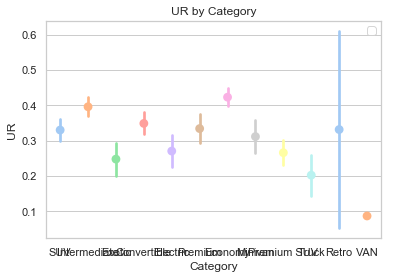

In [43]:
sns.set(style="whitegrid")

g = sns.pointplot(x="Category", y="UR", data=df,
                   height=6, kind="strip", palette="pastel",ci=95,dodge=True,join=False)
plt.title('UR by Category')
plt.legend(loc='upper right')
plt.show()